In [25]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../datasets/MNIST', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='../datasets/MNIST', train=False,
                                  download=True, transform=transform)

num_workers = 0
batch_size_train = 20
batch_size_test = 40

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, num_workers=num_workers)

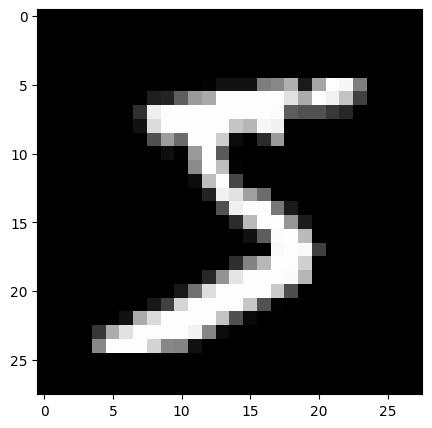

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder_Decoder(nn.Module):
    def __init__(self):
        super(Encoder_Decoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.sigmoid(self.conv_out(x))
                
        return x

model = Encoder_Decoder()
print(model)

Encoder_Decoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [29]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
n_epochs = 30

noise_factor=0.5

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data in train_loader:
        images, _ = data
        
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.919108
Epoch: 2 	Training Loss: 0.630521
Epoch: 3 	Training Loss: 0.579171
Epoch: 4 	Training Loss: 0.556219
Epoch: 5 	Training Loss: 0.542222
Epoch: 6 	Training Loss: 0.530470
Epoch: 7 	Training Loss: 0.522040
Epoch: 8 	Training Loss: 0.515939
Epoch: 9 	Training Loss: 0.509746
Epoch: 10 	Training Loss: 0.505190
Epoch: 11 	Training Loss: 0.500871
Epoch: 12 	Training Loss: 0.497599
Epoch: 13 	Training Loss: 0.494304
Epoch: 14 	Training Loss: 0.490385
Epoch: 15 	Training Loss: 0.488125
Epoch: 16 	Training Loss: 0.485571
Epoch: 17 	Training Loss: 0.483798
Epoch: 18 	Training Loss: 0.481178
Epoch: 19 	Training Loss: 0.480354
Epoch: 20 	Training Loss: 0.478553
Epoch: 21 	Training Loss: 0.476695
Epoch: 22 	Training Loss: 0.475241
Epoch: 23 	Training Loss: 0.473686
Epoch: 24 	Training Loss: 0.473151
Epoch: 25 	Training Loss: 0.471582
Epoch: 26 	Training Loss: 0.471033
Epoch: 27 	Training Loss: 0.469858
Epoch: 28 	Training Loss: 0.468350
Epoch: 29 	Training Loss: 0.4

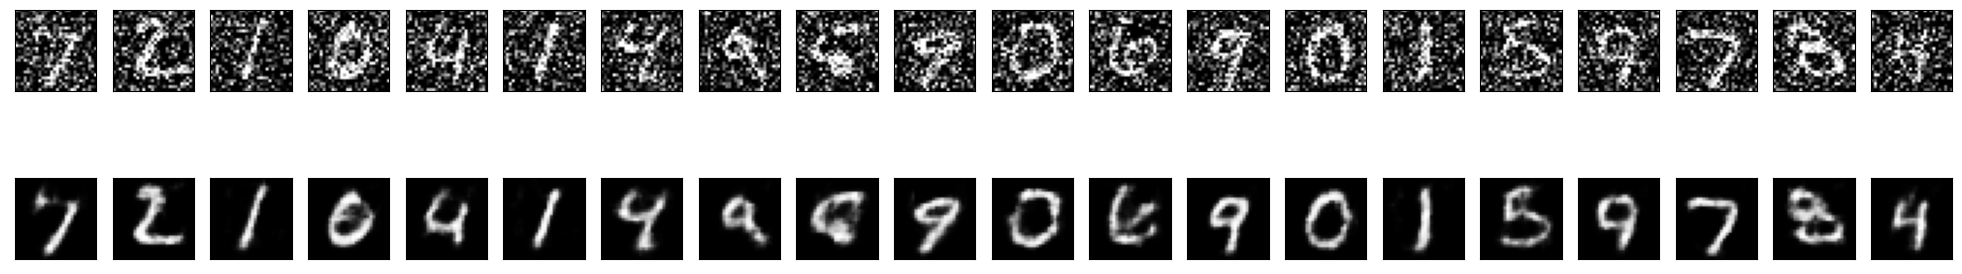

In [31]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# print(images.shape)

noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)
# print(output.shape)
noisy_imgs = noisy_imgs.numpy()

output = output.view(batch_size_test, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=20, sharex=True, sharey=True, figsize=(25,4))

for noisy_imgs, row in zip([noisy_imgs, output], axes):
    # print(row)
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [32]:
torch.save(model.state_dict(),'Encoder-Decoder.pt')